# Imports and spark setup

In [173]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
import findspark
findspark.init()
import pyspark
import random
from pyspark.sql import SparkSession
from pathlib import Path
from src.utils import DisplayablePath
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

In [2]:
def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp', 'string', 'date')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df

In [3]:
def spark_read_csv(filepath):
    df = spark.read.load(filepath,format="csv", inferSchema="true", header="true")
    return df

In [4]:
def dataframe_summary(df):
    print("----------------------")
    #print(df.head(2))
    print(df.printSchema())
    print(f"There are {df.count()} rows")
    

In [5]:
def stop_spark():
    return sc.stop()

In [6]:
APPNAME="ClimateChange"

In [7]:
spark = SparkSession.builder.appName(APPNAME).getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(spark)

21/11/13 11:38:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/Users/jamesmoro/server/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [7]:
stop_spark()

# Data Imports

In [8]:
DATA_DIR = r"/Users/jamesmoro/Documents/Python/ClimateData/data/raw"
paths = DisplayablePath.make_tree(Path(DATA_DIR))
for path in paths:
    print(path.displayable())

raw/
├── .DS_Store
├── .gitkeep
├── climate_change_download_0.xls
├── GlobalTemperatures/
│   ├── GlobalLandTemperaturesByCity.csv
│   ├── GlobalLandTemperaturesByCountry.csv
│   ├── GlobalLandTemperaturesByMajorCity.csv
│   ├── GlobalLandTemperaturesByState.csv
│   ├── GlobalTemperatures.csv
│   └── metadata.txt
└── UNGreenhouseGasInventoryData/
    ├── .DS_Store
    ├── Co2.csv
    ├── Hydrofluorocarbons.csv
    ├── metadata.txt
    ├── Methane.csv
    ├── Nitrogen_trifluoride.csv
    ├── Nitrous_oxide.csv
    ├── Perfluorocarbons.csv
    └── Sulphur_hexafluoride.csv


In [9]:
GLOBALTEMP_DIR = Path(r"/Users/jamesmoro/Documents/Python/ClimateData/data/raw", "GlobalTemperatures/")
GLOBALTEMPS_FILES = [
    "GlobalLandTemperaturesByCity",
    "GlobalLandTemperaturesByCountry",
    "GlobalLandTemperaturesByMajorCity",
    "GlobalLandTemperaturesByState",
    "GlobalTemperatures"
]

In [10]:
globaltemps_paths = [str(Path(GLOBALTEMP_DIR,file+".csv")) for file in GLOBALTEMPS_FILES] #have to convert back to str to read in spark

In [11]:
GREENHOUSEGAS_DIR = Path(r"/Users/jamesmoro/Documents/Python/ClimateData/data/raw", "UNGreenhouseGasInventoryData/")

GREENHOUSEGAS_FILES = [
    "Co2", 
    "Hydrofluorocarbons",
    "Methane", 
    "Nitrogen_trifluoride", 
    "Nitrous_oxide",
    "Perfluorocarbons",
    "Sulphur_hexafluoride",
]

### Greenhouse Gas Files

In [12]:
greenhousegas_paths = [str(Path(GREENHOUSEGAS_DIR,file+".csv")) for file in GREENHOUSEGAS_FILES]

In [13]:
spark_read_csv(greenhousegas_paths[0]).show(2)

+---------------+----+----------------+
|Country or Area|Year|           Value|
+---------------+----+----------------+
|      Australia|2018|415953.946668257|
|      Australia|2017| 415097.42766819|
+---------------+----+----------------+
only showing top 2 rows



In [14]:
greenhousegas_count = {Path(file).stem:(spark_read_csv(file)).count() for file in greenhousegas_paths}
greenhousegas_count

{'Co2': 1247,
 'Hydrofluorocarbons': 1149,
 'Methane': 1247,
 'Nitrogen_trifluoride': 316,
 'Nitrous_oxide': 1247,
 'Perfluorocarbons': 978,
 'Sulphur_hexafluoride': 1207}

In [32]:
CO2 = spark_read_csv(greenhousegas_paths[0])
HFC = spark_read_csv(greenhousegas_paths[1])
CH4 = spark_read_csv(greenhousegas_paths[2])
NF3 = spark_read_csv(greenhousegas_paths[3])
N20 = spark_read_csv(greenhousegas_paths[4])
PFC = spark_read_csv(greenhousegas_paths[5])
SF6 = spark_read_csv(greenhousegas_paths[6])


In [30]:
CO2.printSchema()
CO2.show(5)

root
 |-- Country or Area: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Value: double (nullable = true)

+---------------+----+----------------+
|Country or Area|Year|           Value|
+---------------+----+----------------+
|      Australia|2018|415953.946668257|
|      Australia|2017| 415097.42766819|
|      Australia|2016|411031.531117043|
|      Australia|2015|401554.757230168|
|      Australia|2014|394116.891505507|
+---------------+----+----------------+
only showing top 5 rows



In [48]:
CO2.select(F.countDistinct("Country or Area")).show()

+-------------------------------+
|count(DISTINCT Country or Area)|
+-------------------------------+
|                             43|
+-------------------------------+



43 different countries

In [58]:
CO2.agg({"Year":"min"}).show()
CO2.agg({"Year":"max"}).show()

+---------+
|min(Year)|
+---------+
|     1990|
+---------+

+---------+
|max(Year)|
+---------+
|     2018|
+---------+



# Plotting Emissions

In [139]:
CO2_df = CO2.select("*").toPandas()
HFC_df = HFC.select("*").toPandas()
CH4_df = CH4.select("*").toPandas()
NF3_df = NF3.select("*").toPandas()
N20_df = N20.select("*").toPandas()
PFC_df = PFC.select("*").toPandas()
SF6_df = SF6.select("*").toPandas()
greenhouse_gas_dfs = [CO2_df,
HFC_df,
CH4_df,
NF3_df,
N20_df,
PFC_df,
SF6_df,
]

In [149]:
countries = CO2_df.sort_values(by="Value", ascending = False)["Country or Area"].unique()

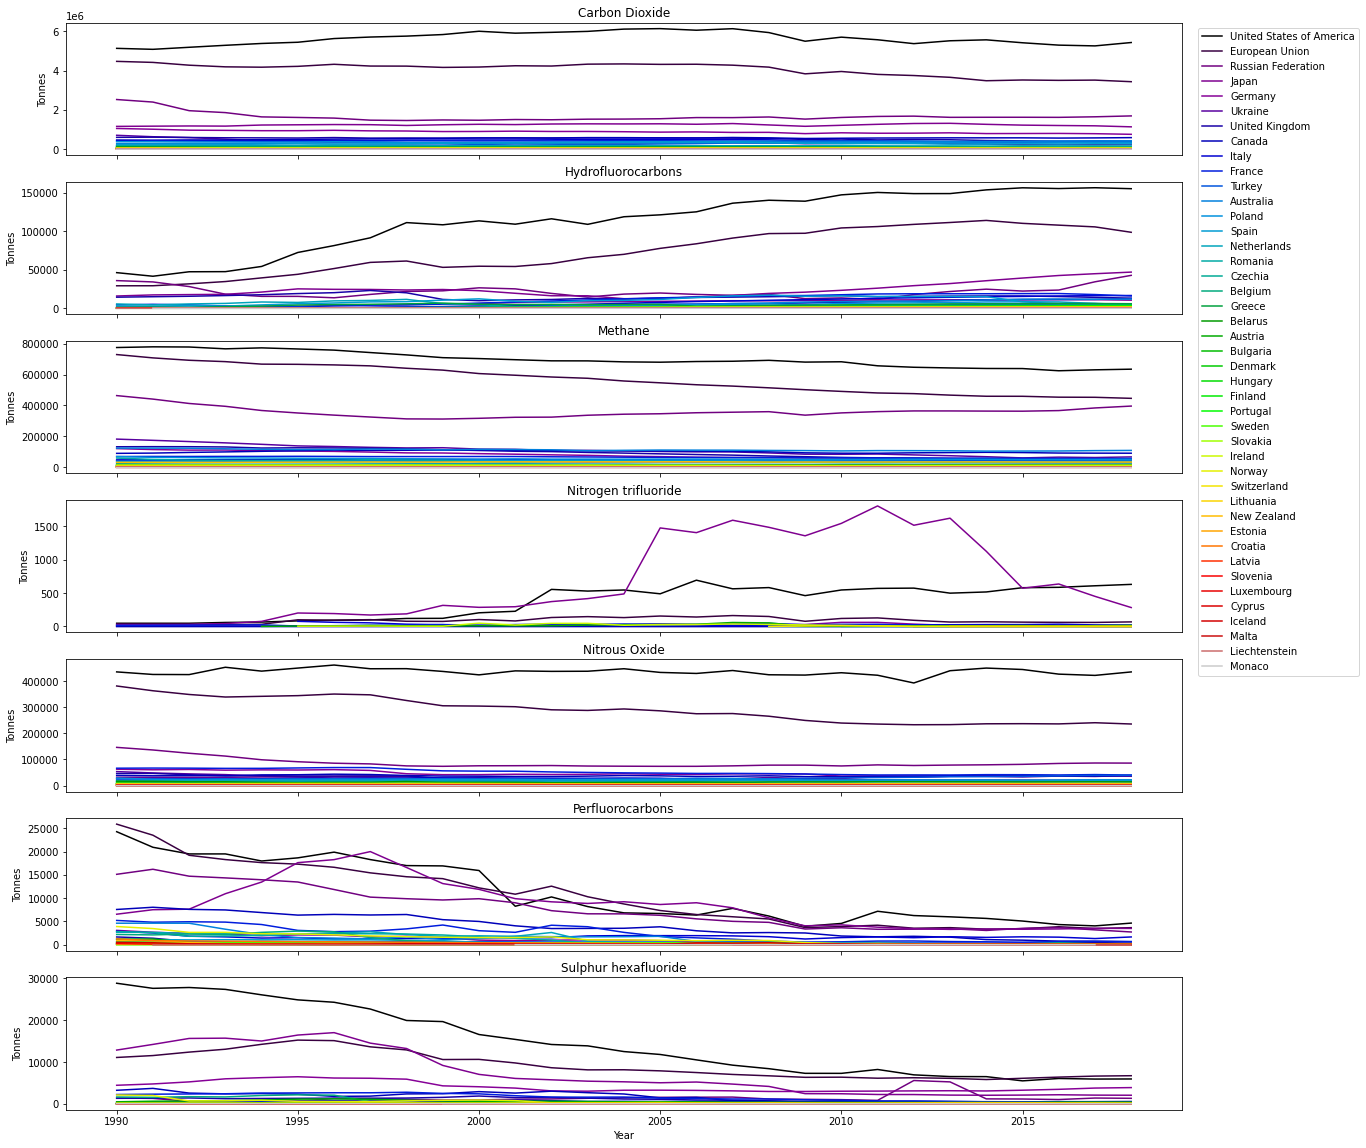

In [152]:
number_of_plots = len(countries)

fig, axs = plt.subplots(nrows = 7, ncols =1, sharex = True, figsize = (20,20))
colormap = plt.cm.nipy_spectral
colors = [colormap(i) for i in np.linspace(0, 1,number_of_plots)]

for ax in axs.flat:
    ax.set_prop_cycle('color', colors)

for graph_index,df in enumerate(greenhouse_gas_dfs):
    for country in countries:
        df_plot = df[df["Country or Area"] == country] 
        axs[graph_index].plot(df_plot["Year"], df_plot["Value"], label = country)

axs[0].set(title="Carbon Dioxide")
axs[1].set(title="Hydrofluorocarbons")
axs[2].set(title="Methane")
axs[3].set(title="Nitrogen trifluoride")
axs[4].set(title="Nitrous Oxide")
axs[5].set(title="Perfluorocarbons")
axs[6].set(title="Sulphur hexafluoride", xlabel="Year")
for ax in axs.flat:
    ax.set(ylabel="Tonnes")
    
axs[0].legend(bbox_to_anchor=(1.01, 1.0))


In [194]:
choropleth_name_df_dict={
    "Carbon Dioxide": CO2_df,
"Hydrofluorocarbons":HFC_df,
"Methane":CH4_df,
"Nitrogen trifluoride":NF3_df,
"Nitrous Oxide":N20_df,
"Perfluorocarbons":PFC_df,
"Sulphur hexafluoride":SF6_df,
}

In [195]:
choropleth_choice=widgets.Select(
    options=["Carbon Dioxide",
"Hydrofluorocarbons",
"Methane",
"Nitrogen trifluoride",
"Nitrous Oxide",
"Perfluorocarbons",
"Sulphur hexafluoride",
],
    value='Carbon Dioxide',
    # rows=10,
    description='GHG',
    disabled=False
)
display(choropleth_choice)

Select(description='GHG', options=('Carbon Dioxide', 'Hydrofluorocarbons', 'Methane', 'Nitrogen trifluoride', …

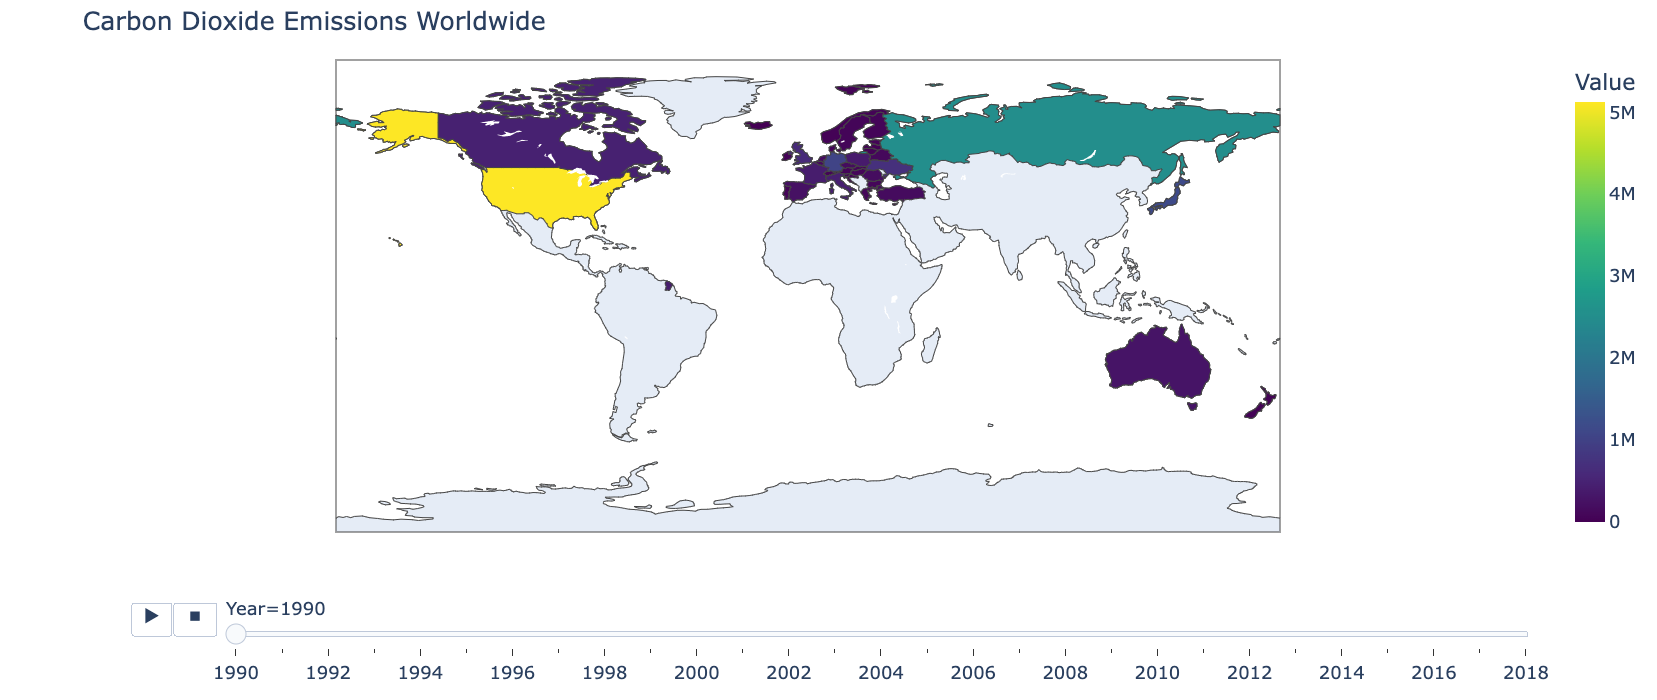

In [209]:
choropleth_plot_df = choropleth_name_df_dict.get(choropleth_choice.value)
fig = px.choropleth(choropleth_plot_df.sort_values(by="Year"), locations="Country or Area",
                    color="Value",
                    hover_name="Country or Area",
                    hover_data=["Value"],
                    locationmode="country names",
                    animation_frame='Year',
                    color_continuous_scale="Viridis")
fig.update_layout(paper_bgcolor="white",height= 700,title_text = f'{choropleth_choice.value} Emissions Worldwide',font_size=18)
fig.show()

In [75]:
CO2_countries = [CO2.select("Country or Area").distinct().collect()[i][0] for i in range(len(CO2.select("Country or Area").distinct().collect()))]

### Globaltemp File

In [15]:
spark_read_csv(globaltemps_paths[0]).show(2)

+----------+------------------+-----------------------------+-----+-------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
only showing top 2 rows



In [16]:
globaltemps_count = {Path(file).stem:(spark_read_csv(file)).count() for file in globaltemps_paths}
globaltemps_count

{'GlobalLandTemperaturesByCity': 8599212,
 'GlobalLandTemperaturesByCountry': 577462,
 'GlobalLandTemperaturesByMajorCity': 239177,
 'GlobalLandTemperaturesByState': 645675,
 'GlobalTemperatures': 3192}

In [17]:
cities = spark_read_csv(globaltemps_paths[0])
country = spark_read_csv(globaltemps_paths[1])
majorcity = spark_read_csv(globaltemps_paths[2])
state = spark_read_csv(globaltemps_paths[3])
globaltemps = spark_read_csv(globaltemps_paths[4])

temp_df_list = [cities,country,majorcity,state,globaltemps]

In [18]:
[dataframe_summary(df) for df in temp_df_list]

----------------------
root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)

None


There are 8599212 rows
----------------------
root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- Country: string (nullable = true)

None
There are 577462 rows
----------------------
root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)

None
There are 239177 rows
----------------------
root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)

None
There are 645675 rows
----------------------
root
 |-- dt: string (nullable = true)
 |-- LandAverageTemperature: double (null

[None, None, None, None, None]